# Гипотезы

Нужно проверить:
- Отличается ли время прохождения различных этапов для пользователей, которые прошли обучение, от пользователей, не начинавших обучение? 
Насколько обучение сокращает время прохождения этапов?
- Существует ли зависимость между вероятностью оплаты тренировки и количеством обучений, которые начинал или завершал пользователь. 
Нужно доказать, что успешное обучение влияет на оплату само по себе, без разницы, какое оно было по порядку.
- Как часто пользователи начинают обучение после того, как они выбрали уровень сложности тренировок? 
Это позволит нам понять, насколько процесс работы с приложением понятен для пользователей: если пользователи после выбора уровня сложности обращаются к обучению, значит, работа с приложением непонятна.

# Проверка гипотез

Проверку будем производить на основе данных пользователей, которые зарегистрировались в 2018 году (с 1 января по 31 декабря 2018 года включительно).

**Импортируем библиотеки**

In [1]:
import pandas as pd 
import psycopg2
import psycopg2.extras 
import numpy as np

**Получаем данные из базы данных**

In [2]:
def getEventsData():
    query = '''SELECT e.* FROM case8.events e
    WHERE e.user_id in
    (SELECT DISTINCT(user_id) 
    FROM case8.events 
    WHERE event_type = 'registration' 
    AND start_time >= '2018-01-01'
    AND start_time < '2019-01-01')
    '''.format()
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data

def getPurchaseData():
    query = '''SELECT p.* FROM case8.purchase p
    WHERE p.user_id in
    (SELECT DISTINCT(user_id) 
    FROM case8.events 
    WHERE event_type = 'registration' 
    AND start_time >= '2018-01-01'
    AND start_time < '2019-01-01')
    '''.format()
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data

events_df = pd.DataFrame(getEventsData())
purchase_df = pd.DataFrame(getPurchaseData())

**Произведем обзор данных и преобразование данных**

In [3]:
events_df['start_time'] = pd.to_datetime(events_df['start_time'])
purchase_df['start_time'] = pd.to_datetime(purchase_df['start_time'])

In [4]:
purchase_df['event_type'] = 'purchase' #объединим датафрейм с событиями вместе с датафреймом по оплатам
events_df = events_df.rename(columns={'id':'event_id'}) #переименуем колонки
purchase_df = purchase_df.rename(columns={'id':'purchase_id'})
total_events_df = pd.concat([events_df,purchase_df],sort=False) #запишем объединенный датафрейм в переменную total_events_df

In [5]:
# Зарегистрировавшиеся пользователи (все):
all_users = total_events_df[total_events_df['event_type'] == 'registration']['user_id'].unique() 
print('Количество зарегистрировавшихся пользователей: {}'.format(len(all_users)))

Количество зарегистрировавшихся пользователей: 24460


**Выделим группы пользователей по прохождению обучения**

In [6]:
# Пользователи, которые начали обучение:
users_with_started_tutorial = total_events_df[total_events_df['event_type'] == 'tutorial_start']['user_id'].unique()
print('Количество пользователей, начавших обучение: {}'.format(len(users_with_started_tutorial)))
percent_users_with_started_tutorial = len(users_with_started_tutorial) / len(all_users)
print ('Процент пользователей, начавших обучение (от общего числа зарегистрировавшихся): {:.2%}'.format(percent_users_with_started_tutorial))

# Пользователи, завершившие обучение:
users_with_finished_tutorial = total_events_df[total_events_df['event_type'] == 'tutorial_finish']['user_id'].unique()
print('Количество пользователей, завершивших обучение: {}'.format(len(users_with_finished_tutorial)))
percent_users_with_finished_tutorial = len(users_with_finished_tutorial) / len(all_users)
print ('Процент пользователей, завершивших обучение (от общего числа зарегистрировавшихся): {:.2%}'.format(percent_users_with_finished_tutorial))

# Пользователи, не начинавшие обучение:
# users_not_started_tutorial = set(all_users).difference(set(users_with_started_tutorial))
users_not_started_tutorial = np.setxor1d(all_users, users_with_started_tutorial)
print('Количество пользователей, не начинавших обучение: {}'.format(len(users_not_started_tutorial)))
percent_users_not_started_tutorial = len(users_not_started_tutorial) / len(all_users)
print ('Процент пользователей, не начинавших обучение (от общего числа зарегистрировавшихся): {:.2%}'.format(percent_users_not_started_tutorial))

Количество пользователей, начавших обучение: 14551
Процент пользователей, начавших обучение (от общего числа зарегистрировавшихся): 59.49%
Количество пользователей, завершивших обучение: 12531
Процент пользователей, завершивших обучение (от общего числа зарегистрировавшихся): 51.23%
Количество пользователей, не начинавших обучение: 9909
Процент пользователей, не начинавших обучение (от общего числа зарегистрировавшихся): 40.51%


Далее будем рассматривать этапы событий для групп: 
- пользователи, завершившие обучение
- пользователи, не начинавшие обучение

Учитывая то, что регистрацию проходят все пользователи, а также что пользователи, не начинавшие обучение, сразу переходят к выбору уровня сложности бесплатных тренировок, тогда как пользователи, выбравшие обучение, будут доходить до этапа выбора уровня сложности некоторое количество времени, считаю нецелесообразным рассматривать определение времени между этапами регистрация и выбор уровня сложности бесплатных тренировок для указанных групп пользователей. Будем рассматривать дальнейшие этапы.

## Анализ гипотезы 1


**Определим отличается ли время прохождения между этапами выбора уровня сложности и выбора тренировок для пользователей, которые завершили обучение, и пользователей, не начинавших обучение:**

In [7]:
user_groups = [
    {'finished': users_with_finished_tutorial},
    {'notstarted': users_not_started_tutorial}
]
meantime_values = []
for group in user_groups:
    level = list(group.keys())[0]
    group_users = group[level]
    level_choice_df = total_events_df[(total_events_df['event_type'] == 'level_choice') 
                                      & (total_events_df['user_id'].isin(group_users))]
    training_choice_df = total_events_df[(total_events_df['event_type'] == 'training_choice') 
                                         & (total_events_df['user_id'].isin(group_users))]
    if (level_choice_df['user_id'].value_counts().mean()) == 1:
        level_choice_df = level_choice_df[['user_id','start_time']].rename(columns={'start_time':'level_choice_time'})
        training_choice_df = training_choice_df[['user_id','start_time']].rename(columns={'start_time':'training_choice_time'})
        merged_df = training_choice_df.merge(level_choice_df,on='user_id',how='inner')
        merged_df['timedelta'] = merged_df['training_choice_time'] - merged_df['level_choice_time']
        mean_time = merged_df['timedelta'].mean()
        meantime_values.append(mean_time)
        print ('Среднее время между выбором уровня сложности и выбором тренировок для пользователей группы {}: {}'.format(level,mean_time))
        print ('Характеристики времени:')
        print (merged_df['timedelta'].describe())
    else:
        print ('Более 1 события выбора уровня сложности')

Среднее время между выбором уровня сложности и выбором тренировок для пользователей группы finished: 0 days 00:05:09.668813
Характеристики времени:
count                      6211
mean     0 days 00:05:09.668813
std      0 days 00:02:43.241217
min             0 days 00:00:15
25%             0 days 00:02:56
50%             0 days 00:04:47
75%             0 days 00:07:01
max             0 days 00:15:35
Name: timedelta, dtype: object
Среднее время между выбором уровня сложности и выбором тренировок для пользователей группы notstarted: 0 days 00:05:31.077922
Характеристики времени:
count                        77
mean     0 days 00:05:31.077922
std      0 days 00:02:46.163027
min             0 days 00:00:11
25%             0 days 00:03:21
50%             0 days 00:05:13
75%             0 days 00:07:28
max             0 days 00:11:49
Name: timedelta, dtype: object


**Определим отличается ли время прохождения между этапами выбора тренировок и оплаты для пользователей, которые завершили  обучение, и пользователей, не начинавших обучение:**

In [8]:
user_groups = [
    {'finished': users_with_finished_tutorial},
    {'notstarted': users_not_started_tutorial}
]
meantime_values1 = []
for group in user_groups:
    level = list(group.keys())[0]
    group_users = group[level]
    purchase_df_1 = purchase_df[purchase_df['user_id'].isin(group_users)]
    training_choice_df = total_events_df[(total_events_df['event_type'] == 'training_choice') 
                                         & (total_events_df['user_id'].isin(group_users))]
    if (training_choice_df['user_id'].value_counts().mean()) == 1:
        training_choice_df2 = training_choice_df[['user_id','start_time']].rename(columns={'start_time':'training_choice_time'})
        purchase_df_2 = purchase_df_1[['user_id','start_time']].rename(columns={'start_time':'purchase_time'})
        merged_df_2 = purchase_df_2.merge(training_choice_df2,on='user_id',how='inner')
        merged_df_2['timedelta'] = merged_df_2['purchase_time'] - merged_df_2['training_choice_time']
        mean_time_2 = merged_df_2['timedelta'].mean()
        meantime_values1.append(mean_time_2)
        print ('Среднее время между выбором тренировок и оплатой для пользователей группы {}: {}'.format(level,mean_time_2))
        print ('Характеристики времени:')
        print (merged_df_2['timedelta'].describe())
    else:
        print ('Более 1 события выбора тренировок')

Среднее время между выбором тренировок и оплатой для пользователей группы finished: 3 days 16:59:07.005614
Характеристики времени:
count                      1781
mean     3 days 16:59:07.005614
std      2 days 03:37:52.042729
min             0 days 01:31:41
25%             1 days 22:51:29
50%             3 days 12:22:50
75%             5 days 06:56:21
max            10 days 07:56:10
Name: timedelta, dtype: object
Среднее время между выбором тренировок и оплатой для пользователей группы notstarted: 3 days 23:07:16.111111
Характеристики времени:
count                        18
mean     3 days 23:07:16.111111
std      1 days 22:59:05.990710
min             1 days 00:16:58
25%             2 days 08:16:01
50%      3 days 17:44:32.500000
75%      5 days 07:25:03.750000
max             8 days 08:24:25
Name: timedelta, dtype: object


In [9]:
# Подготовим данные для создания визуализации
import datetime
from datetime import datetime, timedelta
dt_1 = meantime_values[0]/pd.Timedelta('1 s')
dt_2 = meantime_values[1]/pd.Timedelta('1 s')

dt_3 = meantime_values1[0]/pd.Timedelta('1 hour')
dt_4 = meantime_values1[1]/pd.Timedelta('1 hour')

avertime_df = pd.DataFrame([ [dt_1,dt_3], [dt_2,dt_4]],
                  columns = ['change_level_training', 'change_training_purchase'], 
                  index = ['finished', 'notstarted'])

## Выводы по 1 анализу:

Среднее время между выбором уровня сложности и выбором тренировок для пользователей, завершивших обучение - 5 минут 9 сек.

Среднее время между выбором уровня сложности и выбором тренировок для пользователей, не начинавших обучение - 5 минут 31 сек. 

Среднее время между выбором тренировок и оплатой для пользователей, завершивших обучение - 3 дня 16 часов 59 минут 7 сек. 

Среднее время между выбором тренировок и оплатой для пользователей, не начинавших обучение - 3 дня 23 часа 7 минут 16 сек.

Как мы видим из расчетов, среднее время прохождения от этапа выбора уровня сложности бесплатных тренировок до выбора тренировок не зависит от того, прошли пользователи обучение или нет. Однако, пользователи, завершившие обучение, быстрее совершают оплаты по сравнению с пользователями, не начинавшими обучение. Среднее время прохождения от этапа выбора тренировок до оплаты сокращается на несколько часов (~ 6 часов)

### Визуализация 

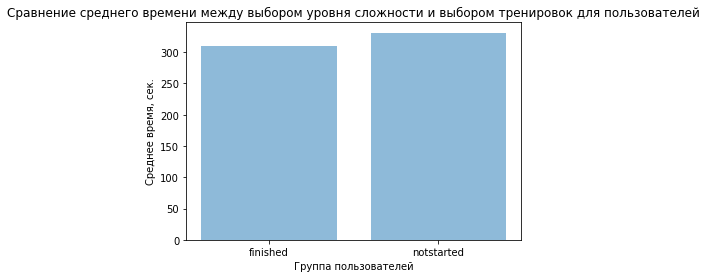

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
avertime_df = pd.DataFrame([[dt_1,dt_3], [dt_2,dt_4]],
                  columns = ['change_level_training', 'change_training_purchase'], 
                  index = ['finished', 'notstarted'])
plt.bar(avertime_df.index, avertime_df['change_level_training'], align='center', alpha=0.5)
plt.xlabel('Группа пользователей')
plt.ylabel('Среднее время, сек.')
plt.title('Сравнение среднего времени между выбором уровня сложности и выбором тренировок для пользователей')

plt.show()

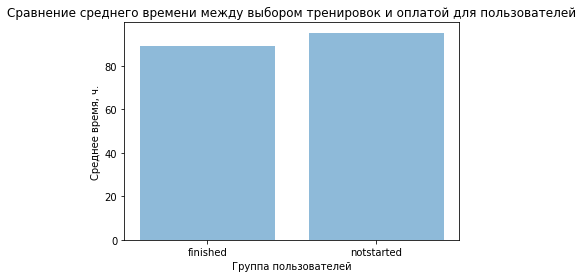

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
avertime_df = pd.DataFrame([[dt_1,dt_3], [dt_2,dt_4]],
                  columns = ['change_level_training', 'change_training_purchase'], 
                  index = ['finished', 'notstarted'])
plt.bar(avertime_df.index, avertime_df['change_training_purchase'], align='center', alpha=0.5)
plt.xlabel('Группа пользователей')
plt.ylabel('Среднее время, ч.')
plt.title('Сравнение среднего времени между выбором тренировок и оплатой для пользователей')

plt.show()

## Анализ гипотезы 2

**Существует ли зависимость между вероятностью оплаты тренировки и количеством обучений, которые начинал или завершал пользователь. Нужно доказать, что успешное обучение влияет на оплату само по себе, без разницы, какое оно было по порядку.**

In [12]:
#Сделаем датафрейм purchase_df_3, в котором будут данные по оплатам всех пользователей:
purchase_df_3 = purchase_df[purchase_df['user_id'].isin(all_users)]
len(purchase_df_3) # количество оплативших пользователей (всего)

1974

In [13]:
#Сделаем датафрейм purchase_df_4, в котором будут данные по оплатам пользователей, которые завершили обучение:
purchase_df_4 = purchase_df[purchase_df['user_id'].isin(users_with_finished_tutorial)]

# Найдем процент завершивших обучение пользователей, оплативших тренировки из числа всех оплативших пользователей:
percent_of_purchase_4 = purchase_df_4['user_id'].nunique()/len(purchase_df_3)
print ('Процент завершивших обучение пользователей, оплативших тренировки (из числа всех оплативших пользователей): {:.2%}'.format(percent_of_purchase_4))

Процент завершивших обучение пользователей, оплативших тренировки (из числа всех оплативших пользователей): 90.22%


In [14]:
#Сделаем датафрейм purchase_df_5, в котором будут данные по оплатам пользователей, которые начали обучение:
purchase_df_5 = purchase_df[purchase_df['user_id'].isin(users_with_started_tutorial)]

# Найдем процент начавших обучение пользователей, оплативших тренировки, из числа всех оплативших пользователей:
percent_of_purchase_5 = purchase_df_5['user_id'].nunique()/len(purchase_df_3)
print ('Процент начавших обучение пользователей, оплативших тренировки (из числа всех оплативших пользователей): {:.2%}'.format(percent_of_purchase_5))

Процент начавших обучение пользователей, оплативших тренировки (из числа всех оплативших пользователей): 99.09%


Найдем какое количество обучений прошли пользователи

In [15]:
# Объединяем датафреймы для начавших обучение и завершивших обучение пользователей:
union_df = pd.concat([purchase_df_4,purchase_df_5], ignore_index=True)['user_id'].unique() 

In [16]:
# Выделим какое количество раз пользователи начали обучение и какое количество раз закончили обучение (вместе)
tmp_df = events_df[events_df['user_id'].isin(union_df)] 
tmp_df[(tmp_df['event_type'] == 'tutorial_start') | (tmp_df['event_type'] == 'tutorial_finish')]['user_id'].value_counts()

49726    18
62844    18
57184    18
51717    18
67994    18
         ..
55777     1
59871     1
58281     1
60286     1
67585     1
Name: user_id, Length: 1956, dtype: int64

In [17]:
# Посмотрим какое количество раз пользователи закончили обучение: 
t_df = tmp_df[(tmp_df['event_type'] == 'tutorial_finish')]['user_id'].value_counts()
t_df_new = pd.DataFrame({'user_id':t_df.index, 'count':t_df.values})
print(t_df_new)
users_t_df = tmp_df[(tmp_df['event_type'] == 'tutorial_finish')]['user_id'].unique()
print(len(users_t_df))

      user_id  count
0       51717      9
1       62844      9
2       57184      9
3       67994      9
4       49726      9
...       ...    ...
1776    72188      1
1777    59785      1
1778    61253      1
1779    49671      1
1780    71681      1

[1781 rows x 2 columns]
1781


Таким образом, пользователи проходили обучение от 1 до 9 раз.

Разделим закончивших обучение пользователей на группы (по количеству раз обучений) и для каждой найдем количество пользователей и проверим наличие события оплаты:

In [18]:
groups = {}
for i in range(1, 10):
    users_group = t_df_new[t_df_new['count'] == i]['user_id'].unique()
    print('Количество пользователей, прошедших обучение {0} раз: {1}'.format(i, len(users_group)))
    # Проверяем наличие события оплаты в каждой группе:
    purchase_group1 = purchase_df[purchase_df['user_id'].isin(users_group)][['user_id','amount']]
    print('Количество событий оплаты среди прошедших обучение {0} раз: {1}'.format(i, len(purchase_group1)))
    percent_purchase_group1 = len(purchase_group1)/len(users_t_df)
    print('Процент оплаты среди прошедших обучение {0} раз (из числа всех оплативших закончивших обучение пользователей): {1:.2%}'.format(i, percent_purchase_group1))
    groups[i] = percent_purchase_group1

Количество пользователей, прошедших обучение 1 раз: 1366
Количество событий оплаты среди прошедших обучение 1 раз: 1366
Процент оплаты среди прошедших обучение 1 раз (из числа всех оплативших закончивших обучение пользователей): 76.70%
Количество пользователей, прошедших обучение 2 раз: 235
Количество событий оплаты среди прошедших обучение 2 раз: 235
Процент оплаты среди прошедших обучение 2 раз (из числа всех оплативших закончивших обучение пользователей): 13.19%
Количество пользователей, прошедших обучение 3 раз: 68
Количество событий оплаты среди прошедших обучение 3 раз: 68
Процент оплаты среди прошедших обучение 3 раз (из числа всех оплативших закончивших обучение пользователей): 3.82%
Количество пользователей, прошедших обучение 4 раз: 34
Количество событий оплаты среди прошедших обучение 4 раз: 34
Процент оплаты среди прошедших обучение 4 раз (из числа всех оплативших закончивших обучение пользователей): 1.91%
Количество пользователей, прошедших обучение 5 раз: 22
Количество со

Таким образом, в каждой группе пользователей, завершивших обучение, содержится событие оплаты, т.е. все пользователи оплачивают обучение.

## Вывод по 2 анализу:

Процент завершивших обучение пользователей, оплативших тренировки (из числа всех оплативших пользователей): **90.22%**

Среди пользователей завершивших обучение, т.е. успешно окончивших обучение, существуют пользователи, которые несколько раз начинали/завершали обучение. 
Анализ данных показал, что независимо от того, сколько раз пользователь проходил обучение, если он прошел обучение успешно (завершил его), в дальнейшем он совершает оплату тренировок.

### Визуализация

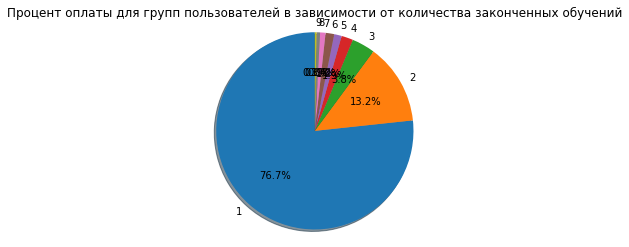

In [19]:
labels = groups.keys()
sizes = groups.values()

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  
plt.title('Процент оплаты для групп пользователей в зависимости от количества законченных обучений')
plt.show()

## Анализ гипотезы 3

**Как часто пользователи начинают обучение после того, как они выбрали уровень сложности тренировок? 
Это позволит нам понять, насколько процесс работы с приложением понятен для пользователей: если пользователи после выбора уровня сложности обращаются к обучению, значит, работа с приложением непонятна.**

In [20]:
#Создадим датафрейм, в котором будут данные по событиям начала обучения и выбора уровня сложности тренировок:
events_level_choice_tutorstart_df = total_events_df[(total_events_df['event_type'] == 'level_choice') | (total_events_df['event_type'] == 'tutorial_start')]
print('Количество событий по началу обучения и выбору уровня сложности тренировок: {}'.format(len(events_level_choice_tutorstart_df)))

Количество событий по началу обучения и выбору уровня сложности тренировок: 32795


In [21]:
users_from_df = events_level_choice_tutorstart_df['user_id'].unique() #найдем количество пользователей в датафрейме events_level_choice_tutorstart_df
len(users_from_df)

14658

In [22]:
events_level_choice_tutorstart_df.sort_values(by=['user_id','start_time'], inplace=True) #отсортируем данные в датафрейме

D:\Utils\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [23]:
# Найдем количество пользователей, которые сначала выбрали уровень сложности тренировки и затем начали обучение:

counter_user = set()
user_id = None
event_type = None

for index, row in events_level_choice_tutorstart_df.iterrows():
    if user_id != row['user_id']:
        user_id = row['user_id']
        event_type = row['event_type']
    else:
        if (event_type != row['event_type'] 
            and event_type == 'level_choice'):
            counter_user.add(user_id)
        else:
            event_type = row['event_type'] 
print('Количество пользователей, которые сначала выбрали уровень сложности тренировки и затем начали обучение: {}'.format(len(counter_user)))

Количество пользователей, которые сначала выбрали уровень сложности тренировки и затем начали обучение: 1769


In [24]:
percent_of_users_selected_level_firstly = len(counter_user) / len(users_from_df)
print ('Процент пользователей, которые сначала выбрали уровень сложности тренировки и затем начали обучение (из числа пользователей, которые начали обучение и выбрали уровень тренировки): {:.2%}'.format(percent_of_users_selected_level_firstly))

Процент пользователей, которые сначала выбрали уровень сложности тренировки и затем начали обучение (из числа пользователей, которые начали обучение и выбрали уровень тренировки): 12.07%


## Вывод по 3 анализу:

Таким образом, мы выяснили, что доля пользователей, которые начинают обучение после того, как они выбрали уровень сложности тренировок (независимо от того, выбрали они уровень тренировки сразу после регистрации и затем приступили к обучению либо прошли обучение, выбрали уровень тренировок и снова начали обучение) составляет **12,07%** из числа пользователей, прошедших этапы обучения и выбора уровня сложности тренировок. 
    
Это позволяет нам считать, что для 12,07% пользователей процесс работы с приложением непонятен.